In [19]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

# Load environment variables from a .env file
load_dotenv()

# Pandas settings for better display in PyCharm
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# CREDENTIALS
API_URL = os.getenv("API_URL")
API_KEY = os.getenv("API_KEY")

print("[+] Libs loaded and settings configured.")

[+] Libs loaded and settings configured.


In [20]:
def get_data_from_api(action_type):
    print(f"[+] Connecting to {API_URL}...")
    try:
        response = requests.get(
            API_URL,
            headers={"Authorization": f"Bearer {API_KEY}"},
            params={"action": action_type}
        )
        if response.status_code == 200:
            data = response.json()
            print(f"[+] Received {len(data)} events.")
            return data
        else:
            print(f"[-] API ERROR: {response.status_code} - {response.text}")
            return []
    except Exception as e:
        print(f"[-] Connexion error: {e}")
        return []

In [21]:
# Download
raw_data = get_data_from_api("RAID_INTERACTION")

if raw_data:
    # Create DataFrame
    df = pd.DataFrame(raw_data)

    # 'context_data' column cleaning
    def clean_json(x):
        if isinstance(x, dict): return x
        try: return json.loads(x)
        except: return {}

    df['context_data'] = df['context_data'].apply(clean_json)

    # Flatten the 'context_data' JSON column
    df_context = pd.json_normalize(df['context_data'])

    # Search for duplicated columns
    duped_columns = df_context.columns.intersection(df.columns)

    # We remove them from the JSON DataFrame because the main table ones are more reliable
    if not duped_columns.empty:
        print(f"[INFO] Deleting duped columns from JSON: {list(duped_columns)}")
        df_context = df_context.drop(columns=duped_columns)
    # -----------------------------------------

    # Join and drop original JSON column
    df_final = df.join(df_context).drop(columns=['context_data'])

    # Create Target (Objective)
    if 'result' in df_final.columns:
        df_final['target'] = df_final['result'].apply(lambda x: 1 if x == 'WIN' else 0)

    print("[+] Data processed correctly:")
    display(df_final.head())
else:
    print("[-] There is any data to process.")

[+] Connecting to http://node-marb.ponchisaohosting.xyz:25589/api/training-data...
[+] Received 36 events.
[INFO] Deleting duped columns from JSON: ['world', 'biome', 'timestamp']
[+] Data processed correctly:


,event_id,server_id,timestamp,player_uuid,category,action_type,world,biome,battleId,playerUuid,bossSpecies,raidTier,result,participantsCount,damageDealt,target
0,2208,yveltal,2026-01-19T16:41:52.736Z,1584ea73-0b41-4913-93c7-2ce1911ae756,COMBAT,RAID_INTERACTION,cobblemonraiddens:raid_den,cobblemonraiddens:1584ea73-0b41-4913-93c7-2ce1...,9b4c9e7c-e67a-42a7-b2e1-73ddb97e40f8,1584ea73-0b41-4913-93c7-2ce1911ae756,Grimer,UNKNOWN,WIN,1,0,1
1,2175,yveltal,2026-01-19T16:37:52.736Z,9a0af0b4-ba02-4928-9d38-cc046df286d6,COMBAT,RAID_INTERACTION,cobblemonraiddens:raid_den,cobblemonraiddens:1584ea73-0b41-4913-93c7-2ce1...,a7b37701-ae5b-47e3-978a-0b616a6ac3ee,9a0af0b4-ba02-4928-9d38-cc046df286d6,Metagross,UNKNOWN,WIN,1,0,1
2,2176,yveltal,2026-01-19T16:37:52.736Z,1584ea73-0b41-4913-93c7-2ce1911ae756,COMBAT,RAID_INTERACTION,cobblemonraiddens:raid_den,cobblemonraiddens:1584ea73-0b41-4913-93c7-2ce1...,6f9d41b9-067d-4d5b-9504-be4b6a64d8b6,1584ea73-0b41-4913-93c7-2ce1911ae756,Metagross,UNKNOWN,WIN,1,0,1
3,2149,yveltal,2026-01-19T16:35:52.752Z,9a0af0b4-ba02-4928-9d38-cc046df286d6,COMBAT,RAID_INTERACTION,cobblemonraiddens:raid_den,cobblemonraiddens:1584ea73-0b41-4913-93c7-2ce1...,61216de3-3aa5-4ca6-98a2-26174567c3b3,9a0af0b4-ba02-4928-9d38-cc046df286d6,Tsareena,UNKNOWN,WIN,1,0,1
4,2150,yveltal,2026-01-19T16:35:52.752Z,c3599f04-4d90-45c3-af0c-5c64201be3de,COMBAT,RAID_INTERACTION,cobblemonraiddens:raid_den,cobblemonraiddens:1584ea73-0b41-4913-93c7-2ce1...,3e4433c2-b338-4e97-bf95-132a45f4906b,c3599f04-4d90-45c3-af0c-5c64201be3de,Tsareena,UNKNOWN,WIN,1,0,1


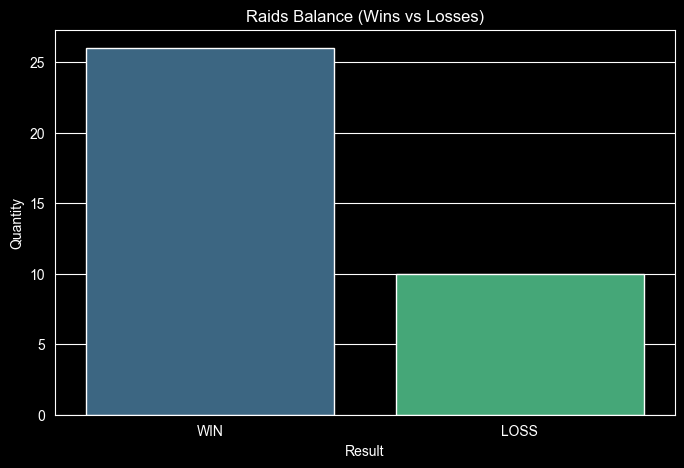

[+] Victory Rate: 72.22%


In [22]:
if 'target' in df_final.columns:
    plt.figure(figsize=(8, 5))

    # Plotting the count of wins and losses
    sns.countplot(x='result', hue='result', data=df_final, palette='viridis', legend=False)

    plt.title('Raids Balance (Wins vs Losses)')
    plt.xlabel('Result')
    plt.ylabel('Quantity')
    plt.show()

    print(f"[+] Victory Rate: {df_final['target'].mean() * 100:.2f}%")

In [23]:
if not df_final.empty:
    df_final.to_csv('dataset_raids_final.csv', index=False)
    print("[+] File 'dataset_raids_final.csv' saved correctly.")

[+] Archivo 'dataset_raids_final.csv' saved correctly.
